In [1]:
def is_start_of_daily_block(date_series):
    """
    Returns a boolean Series indicating if each date in the input Series is the 
    start of a new sequence of consecutive dates.

    :param date_series: Pandas Series with datetime objects.
    :return: Pandas Series of boolean values.
    """
    # Ensure the Series is sorted
    sorted_series = date_series.sort_values()

    # Calculate the difference in days between each date and the previous date
    day_diff = sorted_series.diff().dt.days

    # Mark True where the difference is greater than 1 day, indicating a new sequence
    is_start = day_diff > 1

    # Handle the first element
    if not is_start.empty:
        is_start.iloc[0] = True

    return is_start

In [2]:
import utils

In [3]:
import pandas as pd
import re

extruder = 'EX2'

ex_data = pd.read_csv(f"data/{extruder}_processed.csv")
ex_data['Unnamed: 0'] = pd.to_datetime(ex_data['Unnamed: 0'])
ex_data = ex_data.set_index('Unnamed: 0').rename_axis('Date and Time')
#ex_data.index = pd.to_datetime(ex_data.index)
ex_data.dropna(inplace=True)

In [4]:
type(ex_data.index[0])

pandas._libs.tslibs.timestamps.Timestamp

In [5]:
min_time = ex_data.index.min()
well_sampled_cutoff = min_time + pd.Timedelta(hours=48)
min_time, well_sampled_cutoff

ex_data.loc[ex_data.index < well_sampled_cutoff,'well_sampled'] = False

In [6]:
len(ex_data)

442690

In [7]:
#ex_data['Date and Time'] = ex_data.index

In [8]:
for time_window in ['5T', '15T', '30T', '1H', '3H', '6H', '12H', '24H', '48H']:
    if 'T' in time_window:
        label_append = time_window.replace('T', 'min')
    elif 'H' in time_window:
        label_append = time_window.replace('H', 'hour')

    col_label = 'pressure-' + label_append + '_avg'
    ex_data[col_label] = ex_data['Extruder Pressure'].rolling(time_window).mean()

    col_label = 'pressure-' + label_append + '_var'
    ex_data[col_label] = ex_data['Extruder Pressure'].rolling(time_window).var()

In [9]:
ex_data.columns

Index(['Extruder Pressure', 'Screw Speed Output', 'Screw Speed',
       'Extruder Die Temp', 'Extruder Thrust ', 'Feed Screw Current (Amps)',
       'Discharge Conveyor Current (Amps)', 'Discharge Conveyor Speed (%)',
       'sample_gap_minutes', '48H_max_gap_backward', '1H_max_gap_forward',
       'well_sampled', 'HAZARD_CONDITION', 'hours_to_hazard',
       'hazard_within_24h', 'pressure-5min_avg', 'pressure-5min_var',
       'pressure-15min_avg', 'pressure-15min_var', 'pressure-30min_avg',
       'pressure-30min_var', 'pressure-1hour_avg', 'pressure-1hour_var',
       'pressure-3hour_avg', 'pressure-3hour_var', 'pressure-6hour_avg',
       'pressure-6hour_var', 'pressure-12hour_avg', 'pressure-12hour_var',
       'pressure-24hour_avg', 'pressure-24hour_var', 'pressure-48hour_avg',
       'pressure-48hour_var'],
      dtype='object')

In [10]:
variables_to_lag = ['Extruder Die Temp', 'Extruder Thrust ',
                    'Screw Speed Output']

colname_map = {
    'Extruder Die Temp' : 'die_temp-',
    'Extruder Thrust ' : 'thrust-',
    'Screw Speed Output' : 'screw_speed_output-',
}

for time_window in ['15T', '1H', '3H', '6H']:
    if 'T' in time_window:
        label_append = time_window.replace('T', 'min')
    elif 'H' in time_window:
        label_append = time_window.replace('H', 'hour')
    for lagvar in variables_to_lag:
        col_label = colname_map[lagvar] + label_append + '_avg'
        ex_data[col_label] = \
            ex_data[lagvar].rolling(time_window).mean()

In [11]:
#min_datetime = pauses.min() - pd.Timedelta(days=7)
#max_datetime = pauses.max()#

#time_mask = (ex_data.index >= min_datetime) \
#            & (ex_data.index <= max_datetime)
#ex_data = ex_data[time_mask]#
#
#ex_data = ex_data[redundancy_mask]

In [37]:
target_feature = ['hours_to_hazard']
input_features = [
    'Screw Speed Output',
    'Screw Speed',
    'Extruder Die Temp',
    'Extruder Thrust ',
    'Feed Screw Current (Amps)',
    'Discharge Conveyor Current (Amps)',
    'Discharge Conveyor Speed (%)',
    'pressure-5min_avg',
    'pressure-15min_avg',
    'pressure-30min_avg',
    'pressure-1hour_avg',
    'pressure-3hour_avg',
    'pressure-6hour_avg',
    'pressure-12hour_avg',
    'pressure-24hour_avg',
    'pressure-48hour_avg',
    'pressure-5min_var',
    'pressure-15min_var',
    'pressure-30min_var',
    'pressure-1hour_var',
    'pressure-3hour_var',
    'pressure-6hour_var',
    'pressure-12hour_var',
    'pressure-24hour_var',
    'pressure-48hour_var',
    'die_temp-15min_avg',
    'thrust-15min_avg',
    'die_temp-1hour_avg',
    'thrust-1hour_avg',
    'die_temp-3hour_avg',
    'thrust-3hour_avg',
    'die_temp-6hour_avg',
    'thrust-6hour_avg',
]

well_sampled_data = ex_data[ex_data['well_sampled'] == True]

hours_threshold = 30

model_input = well_sampled_data[well_sampled_data['hours_to_hazard'] <= hours_threshold][input_features]
model_output = well_sampled_data[well_sampled_data['hours_to_hazard'] <= hours_threshold][target_feature]

train_split_cutoff = pd.to_datetime('12/1/2023')
model_input_train = model_input[model_input.index < train_split_cutoff]
model_input_test = model_input[model_input.index >= train_split_cutoff]

model_output_train = model_output[model_output.index < train_split_cutoff]
model_output_test = model_output[model_output.index >= train_split_cutoff]

input variables:
Screw Speed Output
Screw Speed
Extruder Die Temp
Extruder Thrust 
Feed Screw Current (Amps)
Discharge Conveyor Current (Amps)
Discharge Conveyor Speed (%)
pressure-5min_avg
pressure-15min_avg
pressure-30min_avg
pressure-1hour_avg
pressure-3hour_avg
pressure-6hour_avg
pressure-12hour_avg
pressure-24hour_avg
pressure-48hour_avg
pressure-5min_var
pressure-15min_var
pressure-30min_var
pressure-1hour_var
pressure-3hour_var
pressure-6hour_var
pressure-12hour_var
pressure-24hour_var
pressure-48hour_var
die_temp-15min_avg
thrust-15min_avg
die_temp-1hour_avg
thrust-1hour_avg
die_temp-3hour_avg
thrust-3hour_avg
die_temp-6hour_avg
thrust-6hour_avg
here first
here

Current Time: 14:25:56
results for target: hours_to_hazard, model: Linear Regression


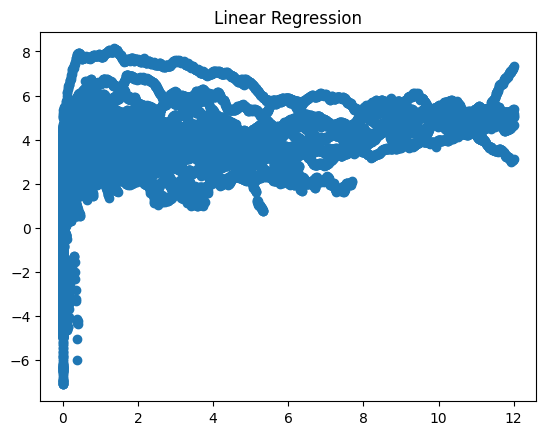

average prediction:  1.8386737252925092, std: 2.1709582615967973
min prediction:  -7.116937482908483, max prediction: 8.136700261385194
{'MSE': 5.778070126965876, 'MAE': 2.0402487947293757, 'R2': -0.10063058569866423}
--------------------------------------
Run time: 0.01 minutes
Current Time: 14:25:56
--------------------------------------

Current Time: 14:25:56
results for target: hours_to_hazard, model: K-Nearest Neighbors Regressor


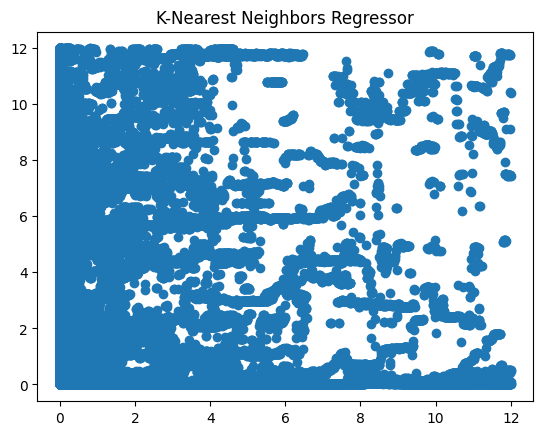

average prediction:  3.11042445002125, std: 3.478015031660533
min prediction:  0.0, max prediction: 11.983333333333334
{'MSE': 21.043304772301042, 'MAE': 3.186019391768365, 'R2': -3.0084153268550278}
--------------------------------------
Run time: 0.15 minutes
Current Time: 14:26:05
--------------------------------------

Current Time: 14:26:05
results for target: hours_to_hazard, model: Random Forest Regressor


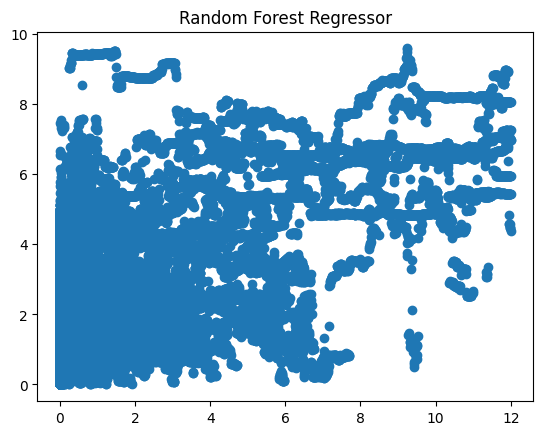

average prediction:  2.637778756248609, std: 2.1602932871103895
min prediction:  0.0, max prediction: 9.589333333333332
{'MSE': 8.498360177972561, 'MAE': 2.1839368738742384, 'R2': -0.6188026338600001}
--------------------------------------
Run time: 4.18 minutes
Current Time: 14:30:06
--------------------------------------

Current Time: 14:30:06
results for target: hours_to_hazard, model: Support Vector Regressor


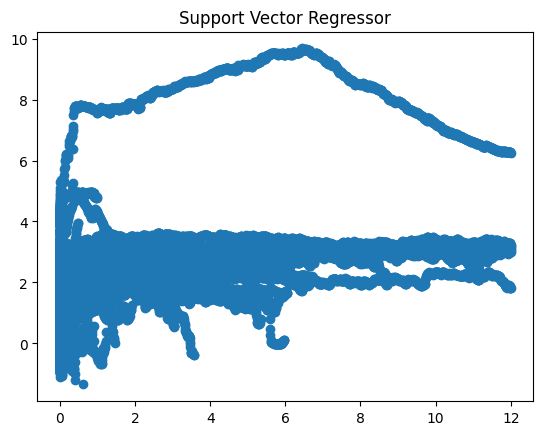

average prediction:  2.316799705471817, std: 1.04742982678693
min prediction:  -1.347902384603284, max prediction: 9.675153822137231
{'MSE': 6.359824435865337, 'MAE': 2.1812375805698174, 'R2': -0.21144554149999917}
--------------------------------------
Run time: 19.54 minutes
Current Time: 14:45:28
--------------------------------------

Current Time: 14:45:28
results for target: hours_to_hazard, model: Gradient Boosting Regressor


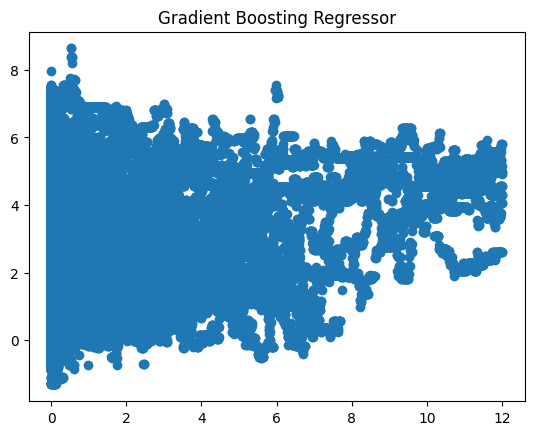

average prediction:  2.7086464614206696, std: 2.179616546306031
min prediction:  -1.3050818064296672, max prediction: 8.629333298481718
{'MSE': 11.097303190121501, 'MAE': 2.540688632072039, 'R2': -1.113859998482365}
--------------------------------------
Run time: 20.89 minutes
Current Time: 14:46:49
--------------------------------------

Current Time: 14:46:49
results for target: hours_to_hazard, model: MLP Regressor


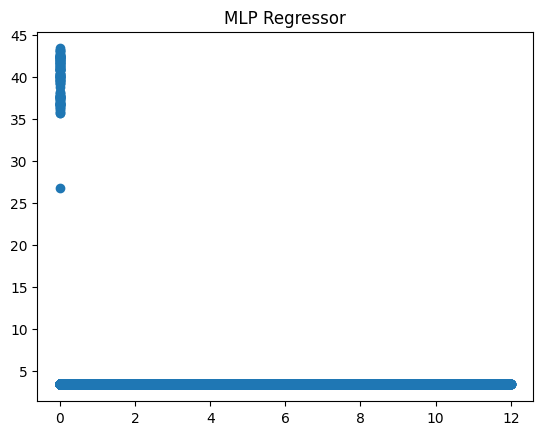

average prediction:  3.3839637877459112, std: 1.1595647676030776
min prediction:  3.3471505339451815, max prediction: 43.40702805743846
{'MSE': 12.214220529576364, 'MAE': 3.1151835139655573, 'R2': -1.3266150115729944}
--------------------------------------
Run time: 21.09 minutes
Current Time: 14:47:01
--------------------------------------


In [44]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

import seaborn as sns
import matplotlib.pyplot as plt

import time
import pickle

print('input variables:')
for var in model_input.columns:
    print(var)

print('here first')
# Define the models to test
models = {
    'Linear Regression': LinearRegression(),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Support Vector Regressor': SVR(),

    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'MLP Regressor': MLPRegressor(hidden_layer_sizes=(16, 32), max_iter=1000)
}

print('here')

# Dictionary to hold the results
results = {}
output_models = {}

saved_processed_data = {}

# Iterate over the models, fit, and evaluate them
start_time = time.time()
results = dict()

targ = 'hours_to_hazard'

results[targ] = dict()
output_models[targ] = dict()
#y = model_output[targ].values

X_train = model_input_train[model_output_train[targ].notnull()].values
X_test = model_input_test[model_output_test[targ].notnull()].values

Y_train = model_output_train[model_output_train[targ].notnull()][targ].values
Y_test = model_output_test[model_output_test[targ].notnull()][targ].values

# Split the data into training and testing sets
#X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#n_true = np.sum((Y_train == 1))
#n_false = np.sum((Y_train == 0))

#print(f'balanced true samples: {n_true}, balanced false samples: {n_false}')
for name, model in models.items():
    print()
    print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
    print(f'results for target: {targ}, model: {name}')
    model.fit(X_train, Y_train)
    output_models[targ][name] = model

    predictions = model.predict(X_test)
    
    plt.scatter(Y_test, predictions)
    plt.title(f'{name}')
    plt.show()
    
    print(f'average prediction:  {np.mean(predictions)}, std: {np.std(predictions)}')
    print(f'min prediction:  {np.min(predictions)}, max prediction: {np.max(predictions)}')
    
    mse = mean_squared_error(Y_test, predictions)
    mae = mean_absolute_error(Y_test, predictions)
    r2 = r2_score(Y_test, predictions)
    
    results[targ][name] = {'MSE': mse, 'MAE': mae, 'R2': r2}

    print(results[targ][name])
    print('--------------------------------------')

    duration = time.time() - start_time
    print(f"Run time: {duration / 60:.2f} minutes")
    print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
    print('--------------------------------------')

with open(f'models/regression_models_no_screw_speed_{extruder}_{hours_threshold}H.pkl', 'wb') as f:
    pickle.dump((output_models, results, input_features, target_features), f)

In [ ]:
#with open(f'models/regression_models_no_screw_speed_{extruder}_{hours_threshold}H.pkl', 'wb') as f:
#    pickle.dump((output_models, results), f)

In [12]:
target_features = ['hours_to_hazard']
input_features = [
    'Screw Speed Output',
    'Screw Speed',
    'Extruder Die Temp',
    'Extruder Thrust ',
    'Feed Screw Current (Amps)',
    'Discharge Conveyor Current (Amps)',
    'Discharge Conveyor Speed (%)',
    'pressure-5min_avg',
    'pressure-1hour_avg',
    'pressure-12hour_avg',
    'pressure-5min_var',
    'pressure-3hour_var',
    'pressure-6hour_var',
    'die_temp-15min_avg',
    'thrust-15min_avg',
    'die_temp-1hour_avg',
    'thrust-1hour_avg',
    'die_temp-6hour_avg',
    'thrust-6hour_avg',
]

well_sampled_data = ex_data[ex_data['well_sampled'] == True]

hours_threshold = 30

model_input = well_sampled_data[well_sampled_data['hours_to_hazard'] <= hours_threshold][input_features]
model_output = well_sampled_data[well_sampled_data['hours_to_hazard'] <= hours_threshold][target_features]

train_split_cutoff = pd.to_datetime('12/1/2023')
model_input_train = model_input[model_input.index < train_split_cutoff]
model_input_test = model_input[model_input.index >= train_split_cutoff]

model_output_train = model_output[model_output.index < train_split_cutoff]
model_output_test = model_output[model_output.index >= train_split_cutoff]

input variables:
Screw Speed Output
Screw Speed
Extruder Die Temp
Extruder Thrust 
Feed Screw Current (Amps)
Discharge Conveyor Current (Amps)
Discharge Conveyor Speed (%)
pressure-5min_avg
pressure-1hour_avg
pressure-12hour_avg
pressure-5min_var
pressure-3hour_var
pressure-6hour_var
die_temp-15min_avg
thrust-15min_avg
die_temp-1hour_avg
thrust-1hour_avg
die_temp-6hour_avg
thrust-6hour_avg
here first
here

Current Time: 15:12:31
results for target: hours_to_hazard, model: Linear Regression


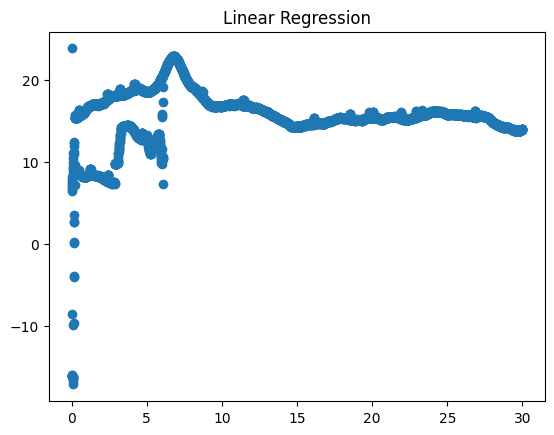

average prediction:  15.308983812113306, std: 3.5769617942415732
min prediction:  -17.139828372266166, max prediction: 23.826999795853084
{'MSE': 94.71386575606004, 'MAE': 8.53571254608981, 'R2': -0.1419147773488938}
--------------------------------------
Run time: 0.00 minutes
Current Time: 15:12:31
--------------------------------------

Current Time: 15:12:31
results for target: hours_to_hazard, model: K-Nearest Neighbors Regressor


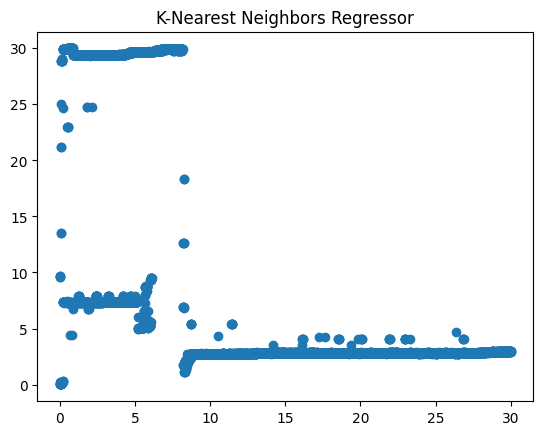

average prediction:  9.486217889555453, std: 10.823165834789735
min prediction:  0.009999999999999981, max prediction: 29.98333333333333
{'MSE': 330.6829829930011, 'MAE': 16.143446008306412, 'R2': -2.986869101828}
--------------------------------------
Run time: 0.02 minutes
Current Time: 15:12:32
--------------------------------------

Current Time: 15:12:32
results for target: hours_to_hazard, model: Random Forest Regressor


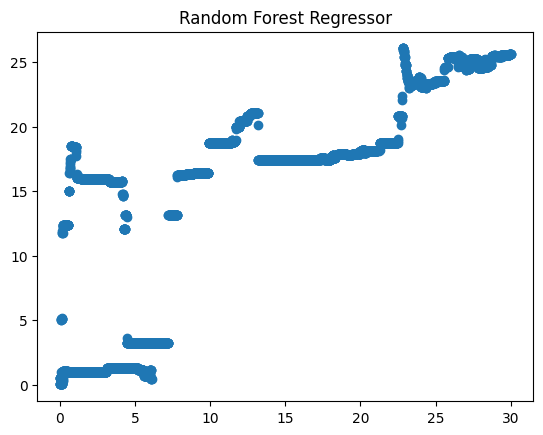

average prediction:  14.903826699738497, std: 8.21171992442289
min prediction:  0.01649999999999997, max prediction: 26.07533333333332
{'MSE': 35.65645946741685, 'MAE': 4.354617847254269, 'R2': 0.5701090051729832}
--------------------------------------
Run time: 0.25 minutes
Current Time: 15:12:46
--------------------------------------

Current Time: 15:12:46
results for target: hours_to_hazard, model: Support Vector Regressor


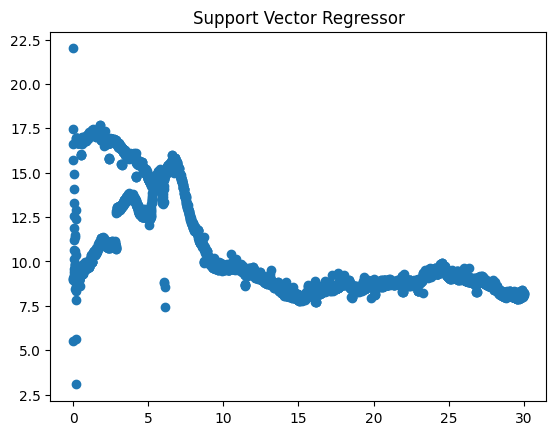

average prediction:  10.893164405223285, std: 2.9489957204145685
min prediction:  3.0725923133423976, max prediction: 21.995436409949278
{'MSE': 134.75891637083123, 'MAE': 10.362735216736153, 'R2': -0.6247166848802188}
--------------------------------------
Run time: 0.46 minutes
Current Time: 15:12:59
--------------------------------------

Current Time: 15:12:59
results for target: hours_to_hazard, model: Gradient Boosting Regressor


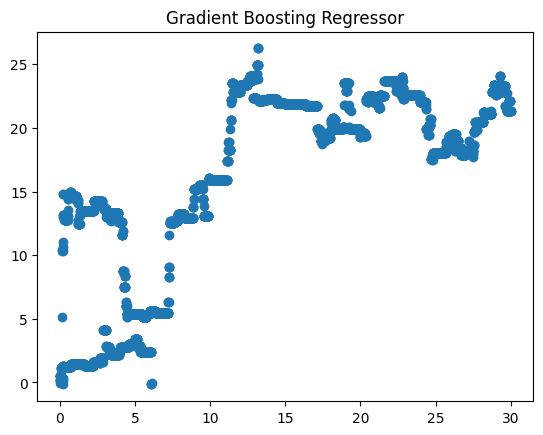

average prediction:  14.98399894565207, std: 7.7257667792673095
min prediction:  -0.15824170111773483, max prediction: 26.23591005351908
{'MSE': 38.81635872718209, 'MAE': 4.866179068693735, 'R2': 0.532011778005071}
--------------------------------------
Run time: 0.56 minutes
Current Time: 15:13:04
--------------------------------------

Current Time: 15:13:04
results for target: hours_to_hazard, model: MLP Regressor


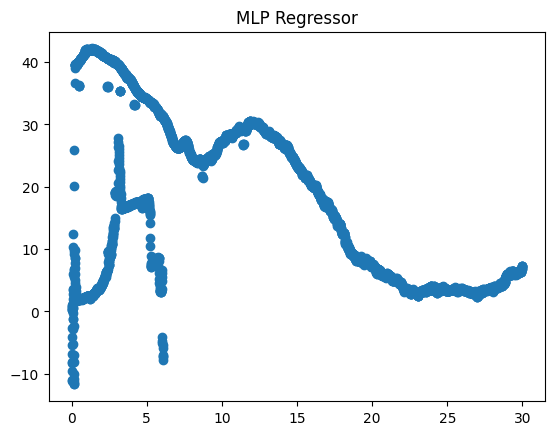

average prediction:  17.761559738954855, std: 13.020148570562576
min prediction:  -11.711025249682466, max prediction: 42.170278007786465
{'MSE': 417.1625100524963, 'MAE': 17.670170959788884, 'R2': -4.029506830729511}
--------------------------------------
Run time: 0.96 minutes
Current Time: 15:13:28
--------------------------------------


In [13]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt

import time
import pickle

print('input variables:')
for var in model_input.columns:
    print(var)

print('here first')
# Define the models to test
models = {
    'Linear Regression': LinearRegression(),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Support Vector Regressor': SVR(),

    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'MLP Regressor': MLPRegressor(hidden_layer_sizes=(16, 32), max_iter=1000)
}

print('here')

# Dictionary to hold the results
results = {}
output_models = {}

saved_processed_data = {}

# Iterate over the models, fit, and evaluate them
start_time = time.time()
results = dict()

targ = 'hours_to_hazard'

results[targ] = dict()
output_models[targ] = dict()
#y = model_output[targ].values

X_train = model_input_train[model_output_train[targ].notnull()].values
X_test = model_input_test[model_output_test[targ].notnull()].values

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
output_models['_scaling'] = scaler

Y_train = model_output_train[model_output_train[targ].notnull()][targ].values
Y_test = model_output_test[model_output_test[targ].notnull()][targ].values

# Split the data into training and testing sets
#X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#n_true = np.sum((Y_train == 1))
#n_false = np.sum((Y_train == 0))

#print(f'balanced true samples: {n_true}, balanced false samples: {n_false}')
for name, model in models.items():
    print()
    print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
    print(f'results for target: {targ}, model: {name}')
    model.fit(X_train, Y_train)
    output_models[targ][name] = model

    predictions = model.predict(X_test)
    
    plt.scatter(Y_test, predictions)
    plt.title(f'{name}')
    plt.show()
    
    print(f'average prediction:  {np.mean(predictions)}, std: {np.std(predictions)}')
    print(f'min prediction:  {np.min(predictions)}, max prediction: {np.max(predictions)}')
    
    mse = mean_squared_error(Y_test, predictions)
    mae = mean_absolute_error(Y_test, predictions)
    r2 = r2_score(Y_test, predictions)
    
    results[targ][name] = {'MSE': mse, 'MAE': mae, 'R2': r2}

    print(results[targ][name])
    print('--------------------------------------')

    duration = time.time() - start_time
    print(f"Run time: {duration / 60:.2f} minutes")
    print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
    print('--------------------------------------')

with open(f'models/regression_models_no_screw_speed_with_normalization_{extruder}_{hours_threshold}H.pkl', 'wb') as f:
    pickle.dump((output_models, results, input_features, target_features), f)

In [46]:
#with open(f'models/regression_models_no_screw_speed_with_normalization_{extruder}_{hours_threshold}H.pkl', 'wb') as f:
#    pickle.dump((output_models, results, input_features, target_features), f)

In [14]:
target_features = ['hours_to_hazard']
input_features = [
    'Screw Speed Output',
    'Screw Speed',
    'Extruder Die Temp',
    'Extruder Thrust ',
    'Feed Screw Current (Amps)',
    'Discharge Conveyor Current (Amps)',
    'Discharge Conveyor Speed (%)',
    'pressure-5min_avg',
    'pressure-1hour_avg',
    'pressure-12hour_avg',
    'pressure-5min_var',
    'pressure-3hour_var',
    'pressure-6hour_var',
    'die_temp-15min_avg',
    'thrust-15min_avg',
    'die_temp-1hour_avg',
    'thrust-1hour_avg',
    'die_temp-6hour_avg',
    'thrust-6hour_avg',
]

well_sampled_data = ex_data[ex_data['well_sampled'] == True]

hours_threshold = 30

model_input = well_sampled_data[well_sampled_data['hours_to_hazard'] <= hours_threshold][input_features]
model_output = well_sampled_data[well_sampled_data['hours_to_hazard'] <= hours_threshold][target_features]

train_split_cutoff = pd.to_datetime('12/1/2023')
model_input_train = model_input[model_input.index < train_split_cutoff]
model_input_test = model_input[model_input.index >= train_split_cutoff]

model_output_train = model_output[model_output.index < train_split_cutoff]
model_output_test = model_output[model_output.index >= train_split_cutoff]

input variables:
Screw Speed Output
Screw Speed
Extruder Die Temp
Extruder Thrust 
Feed Screw Current (Amps)
Discharge Conveyor Current (Amps)
Discharge Conveyor Speed (%)
pressure-5min_avg
pressure-1hour_avg
pressure-12hour_avg
pressure-5min_var
pressure-3hour_var
pressure-6hour_var
die_temp-15min_avg
thrust-15min_avg
die_temp-1hour_avg
thrust-1hour_avg
die_temp-6hour_avg
thrust-6hour_avg
here first
here

Current Time: 15:15:14
results for target: hours_to_hazard, model: Linear Regression


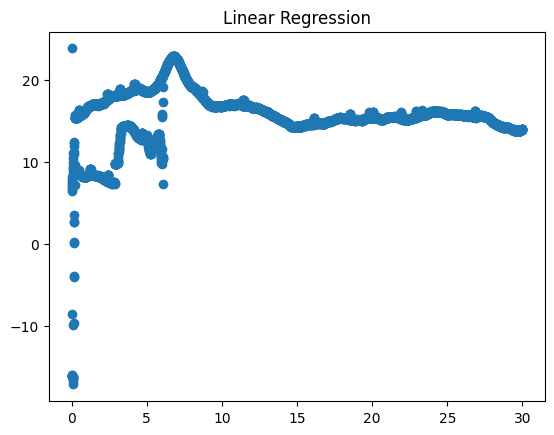

average prediction:  15.308983812112793, std: 3.576961794242
min prediction:  -17.13982837232676, max prediction: 23.826999796430513
{'MSE': 94.71386575600795, 'MAE': 8.535712546086359, 'R2': -0.14191477734826563}
--------------------------------------
Run time: 0.00 minutes
Current Time: 15:15:14
--------------------------------------

Current Time: 15:15:14
results for target: hours_to_hazard, model: K-Nearest Neighbors Regressor


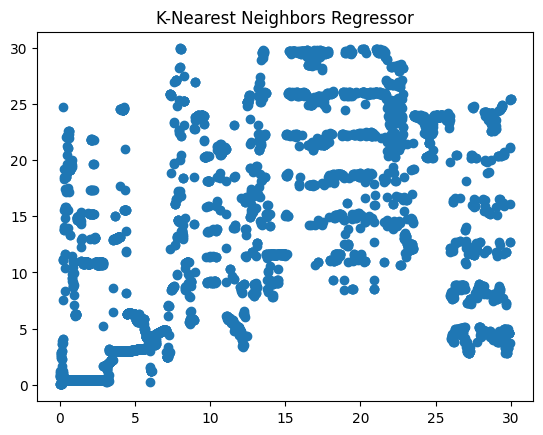

average prediction:  13.344782725734502, std: 9.272879446749739
min prediction:  0.02499999999999996, max prediction: 29.93333333333333
{'MSE': 84.66629021496692, 'MAE': 6.63008883248731, 'R2': -0.020776495268274076}
--------------------------------------
Run time: 0.02 minutes
Current Time: 15:15:15
--------------------------------------

Current Time: 15:15:15
results for target: hours_to_hazard, model: Random Forest Regressor


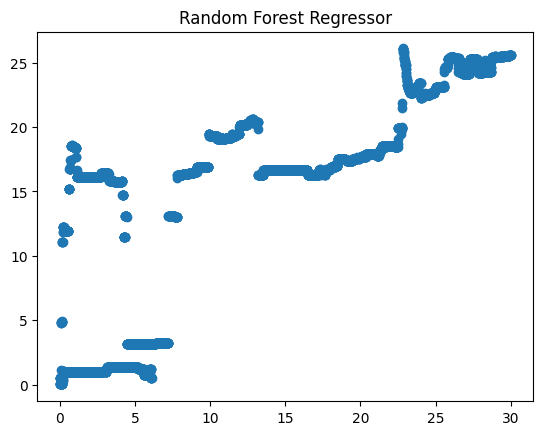

average prediction:  14.697859675434547, std: 8.090101753594512
min prediction:  0.02241666666666663, max prediction: 26.093499999999985
{'MSE': 36.23327732166526, 'MAE': 4.422894939240117, 'R2': 0.5631546186494578}
--------------------------------------
Run time: 0.25 minutes
Current Time: 15:15:29
--------------------------------------

Current Time: 15:15:29
results for target: hours_to_hazard, model: Support Vector Regressor


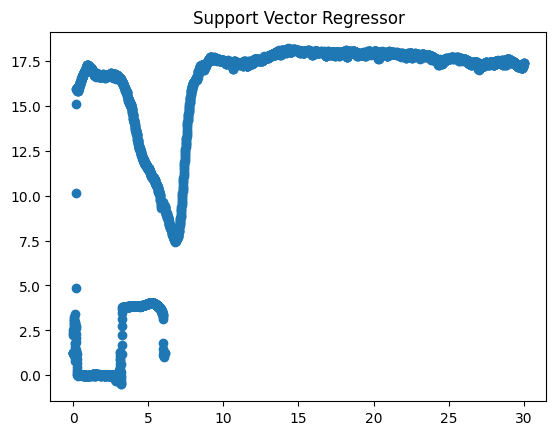

average prediction:  14.031132267591216, std: 6.075778950922166
min prediction:  -0.5084012895466072, max prediction: 18.182474672570102
{'MSE': 51.779338178841094, 'MAE': 5.709909710791277, 'R2': 0.3757240193315491}
--------------------------------------
Run time: 0.46 minutes
Current Time: 15:15:41
--------------------------------------

Current Time: 15:15:41
results for target: hours_to_hazard, model: Gradient Boosting Regressor


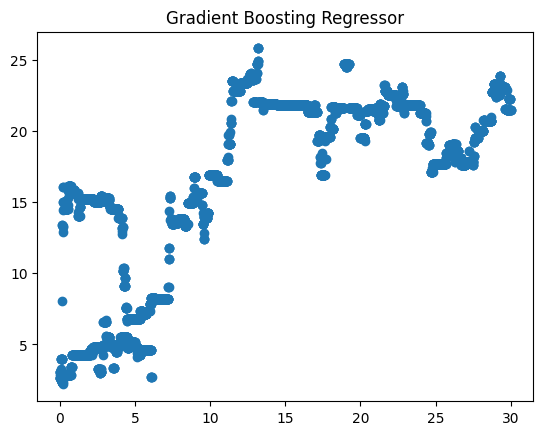

average prediction:  15.72228169393768, std: 6.684264986221185
min prediction:  2.193114748589237, max prediction: 25.77411677293931
{'MSE': 45.06374193307721, 'MAE': 5.3912271608286275, 'R2': 0.4566903966463285}
--------------------------------------
Run time: 0.55 minutes
Current Time: 15:15:47
--------------------------------------

Current Time: 15:15:47
results for target: hours_to_hazard, model: MLP Regressor


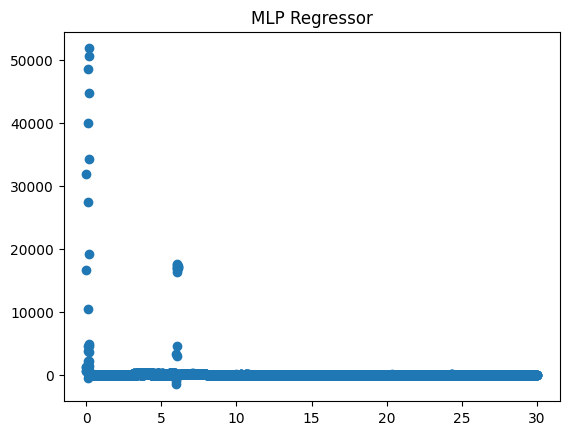

average prediction:  167.47449032435472, std: 2014.5542091053385
min prediction:  -1534.0206127158513, max prediction: 51810.51552352544
{'MSE': 4085659.596943147, 'MAE': 171.78384193941235, 'R2': -49257.627886468625}
--------------------------------------
Run time: 0.56 minutes
Current Time: 15:15:48
--------------------------------------


In [15]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

import seaborn as sns
import matplotlib.pyplot as plt

import time
import pickle

print('input variables:')
for var in model_input.columns:
    print(var)

print('here first')
# Define the models to test
models = {
    'Linear Regression': LinearRegression(),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Support Vector Regressor': SVR(),

    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'MLP Regressor': MLPRegressor(hidden_layer_sizes=(16, 32), max_iter=1000)
}

print('here')

# Dictionary to hold the results
results = {}
output_models = {}

saved_processed_data = {}

# Iterate over the models, fit, and evaluate them
start_time = time.time()
results = dict()

targ = 'hours_to_hazard'

results[targ] = dict()
output_models[targ] = dict()
#y = model_output[targ].values

X_train = model_input_train[model_output_train[targ].notnull()].values
X_test = model_input_test[model_output_test[targ].notnull()].values

Y_train = model_output_train[model_output_train[targ].notnull()][targ].values
Y_test = model_output_test[model_output_test[targ].notnull()][targ].values

# Split the data into training and testing sets
#X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#n_true = np.sum((Y_train == 1))
#n_false = np.sum((Y_train == 0))

#print(f'balanced true samples: {n_true}, balanced false samples: {n_false}')
for name, model in models.items():
    print()
    print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
    print(f'results for target: {targ}, model: {name}')
    model.fit(X_train, Y_train)
    output_models[targ][name] = model

    predictions = model.predict(X_test)
    
    plt.scatter(Y_test, predictions)
    plt.title(f'{name}')
    plt.show()
    
    print(f'average prediction:  {np.mean(predictions)}, std: {np.std(predictions)}')
    print(f'min prediction:  {np.min(predictions)}, max prediction: {np.max(predictions)}')
    
    mse = mean_squared_error(Y_test, predictions)
    mae = mean_absolute_error(Y_test, predictions)
    r2 = r2_score(Y_test, predictions)
    
    results[targ][name] = {'MSE': mse, 'MAE': mae, 'R2': r2}

    print(results[targ][name])
    print('--------------------------------------')

    duration = time.time() - start_time
    print(f"Run time: {duration / 60:.2f} minutes")
    print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
    print('--------------------------------------')

with open(f'models/regression_models_no_screw_speed_no_normalization_{extruder}_{hours_threshold}H.pkl', 'wb') as f:
    pickle.dump((output_models, results, input_features, target_features), f)

In [51]:
target_feature = ['hours_to_hazard']
input_features = [
    'Screw Speed Output',
    'Screw Speed',
    'Extruder Die Temp',
    'Extruder Thrust ',
    'Feed Screw Current (Amps)',
    'Discharge Conveyor Current (Amps)',
    'Discharge Conveyor Speed (%)']

well_sampled_data = ex_data[ex_data['well_sampled'] == True]

hours_threshold = 30

model_input = well_sampled_data[well_sampled_data['hours_to_hazard'] <= hours_threshold][input_features]
model_output = well_sampled_data[well_sampled_data['hours_to_hazard'] <= hours_threshold][target_feature]

train_split_cutoff = pd.to_datetime('12/1/2023')
model_input_train = model_input[model_input.index < train_split_cutoff]
model_input_test = model_input[model_input.index >= train_split_cutoff]

model_output_train = model_output[model_output.index < train_split_cutoff]
model_output_test = model_output[model_output.index >= train_split_cutoff]

input variables:
Screw Speed Output
Screw Speed
Extruder Die Temp
Extruder Thrust 
Feed Screw Current (Amps)
Discharge Conveyor Current (Amps)
Discharge Conveyor Speed (%)
here first
here

Current Time: 14:52:23
results for target: hours_to_hazard, model: Linear Regression


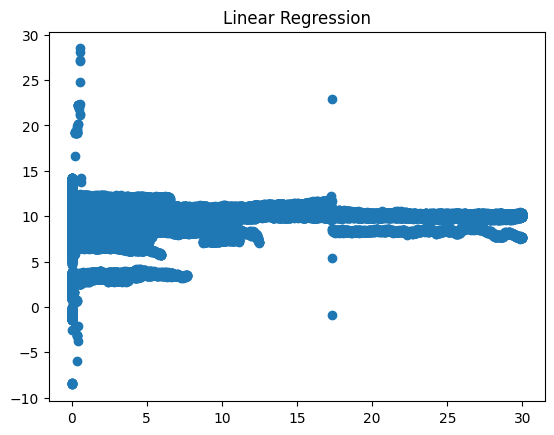

average prediction:  8.376707108738579, std: 2.8549650753757745
min prediction:  -8.550264825757234, max prediction: 28.475501978459533
{'MSE': 72.36673332516173, 'MAE': 7.625421313300662, 'R2': -0.6547291801246231}
--------------------------------------
Run time: 0.01 minutes
Current Time: 14:52:23
--------------------------------------

Current Time: 14:52:23
results for target: hours_to_hazard, model: K-Nearest Neighbors Regressor


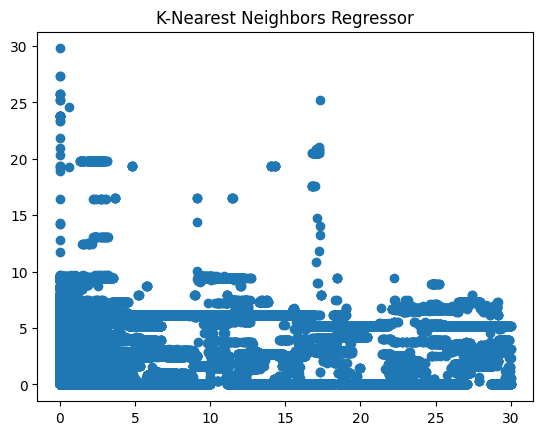

average prediction:  2.2738103747805787, std: 2.4915712252829927
min prediction:  0.0, max prediction: 29.78333333333333
{'MSE': 47.29956776744261, 'MAE': 3.954128075667916, 'R2': -0.08154633207487594}
--------------------------------------
Run time: 0.02 minutes
Current Time: 14:52:24
--------------------------------------

Current Time: 14:52:24
results for target: hours_to_hazard, model: Random Forest Regressor


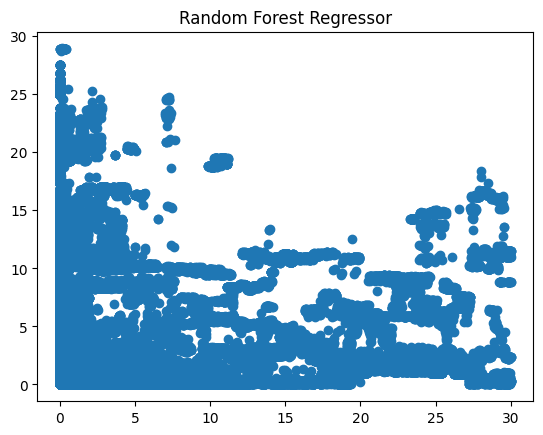

average prediction:  4.7384925071692185, std: 5.931371306078472
min prediction:  0.0, max prediction: 28.936833333333315
{'MSE': 82.98308769774368, 'MAE': 5.990022071515246, 'R2': -0.8974814857720432}
--------------------------------------
Run time: 0.58 minutes
Current Time: 14:52:58
--------------------------------------

Current Time: 14:52:58
results for target: hours_to_hazard, model: Support Vector Regressor


In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

import seaborn as sns
import matplotlib.pyplot as plt

import time
import pickle

print('input variables:')
for var in model_input.columns:
    print(var)

print('here first')
# Define the models to test
models = {
    'Linear Regression': LinearRegression(),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Support Vector Regressor': SVR(),

    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'MLP Regressor': MLPRegressor(hidden_layer_sizes=(16, 32), max_iter=1000)
}

print('here')

# Dictionary to hold the results
results = {}
output_models = {}

saved_processed_data = {}

# Iterate over the models, fit, and evaluate them
start_time = time.time()
results = dict()

targ = 'hours_to_hazard'

results[targ] = dict()
output_models[targ] = dict()
#y = model_output[targ].values

X_train = model_input_train[model_output_train[targ].notnull()].values
X_test = model_input_test[model_output_test[targ].notnull()].values

Y_train = model_output_train[model_output_train[targ].notnull()][targ].values
Y_test = model_output_test[model_output_test[targ].notnull()][targ].values

# Split the data into training and testing sets
#X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#n_true = np.sum((Y_train == 1))
#n_false = np.sum((Y_train == 0))

#print(f'balanced true samples: {n_true}, balanced false samples: {n_false}')
for name, model in models.items():
    print()
    print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
    print(f'results for target: {targ}, model: {name}')
    model.fit(X_train, Y_train)
    output_models[targ][name] = model

    predictions = model.predict(X_test)
    
    plt.scatter(Y_test, predictions)
    plt.title(f'{name}')
    plt.show()
    
    print(f'average prediction:  {np.mean(predictions)}, std: {np.std(predictions)}')
    print(f'min prediction:  {np.min(predictions)}, max prediction: {np.max(predictions)}')
    
    mse = mean_squared_error(Y_test, predictions)
    mae = mean_absolute_error(Y_test, predictions)
    r2 = r2_score(Y_test, predictions)
    
    results[targ][name] = {'MSE': mse, 'MAE': mae, 'R2': r2}

    print(results[targ][name])
    print('--------------------------------------')

    duration = time.time() - start_time
    print(f"Run time: {duration / 60:.2f} minutes")
    print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
    print('--------------------------------------')

In [ ]:
with open(f'models/regression_models_base_only_{extruder}_{hours_threshold}H.pkl', 'wb') as f:
    pickle.dump((output_models, results), f)

In [47]:
target_features = ['hours_to_hazard']
input_features = [
    'Screw Speed Output',
    'Screw Speed',
    'Extruder Die Temp',
    'Extruder Thrust',
    'Feed Screw Current (Amps)',
    'Discharge Conveyor Current (Amps)',
    'Discharge Conveyor Speed (%)',
    'pressure-15min_avg',
    'pressure-30min_avg',
    'pressure-1hour_avg',
    'pressure-3hour_avg',
    'pressure-6hour_avg',
    'pressure-12hour_avg',
    'pressure-24hour_avg',
    'pressure-48hour_avg',
    'pressure-5min_var',
    'pressure-15min_var',
    'pressure-30min_var',
    'pressure-1hour_var',
    'pressure-3hour_var',
    'pressure-6hour_var',
    'pressure-12hour_var',
    'pressure-24hour_var',
    'pressure-48hour_var',
    'die_temp-15min_avg',
    'thrust-15min_avg',
    'screw_speed_output-15min_avg',
    'die_temp-1hour_avg',
    'thrust-1hour_avg',
    'screw_speed_output-1hour_avg',
    'die_temp-3hour_avg',
    'thrust-3hour_avg',
    'screw_speed_output-3hour_avg',
]

In [48]:
#model_input = ex_data[ex_data['hours_to_next_pause'] <= 6][input_features]
#model_output = ex_data[ex_data['hours_to_next_pause'] <= 6][target_features]

In [49]:
train_split_cutoff = pd.to_datetime('12/1/2023')
model_input_train = model_input[model_input.index < train_split_cutoff]
model_input_test = model_input[model_input.index >= train_split_cutoff]

model_output_train = model_output[model_output.index < train_split_cutoff]
model_output_test = model_output[model_output.index >= train_split_cutoff]

In [50]:
print('input variables:')
for var in model_input.columns:
    print(var)

# Define the models to test
models = {
    'Linear Regression': LinearRegression(),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Support Vector Regressor': SVR(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'MLP Regressor': MLPRegressor(hidden_layer_sizes=(16, 32), max_iter=1000)
}

# Dictionary to hold the results
results = {}
output_models = {}

saved_processed_data = {}

# Iterate over the models, fit, and evaluate them
start_time = time.time()
results = dict()

targ = 'hours_to_next_pause'

results[targ] = dict()
output_models[targ] = dict()
#y = model_output[targ].values

X_train = model_input_train[model_output_train[targ].notnull()].values
X_test = model_input_test[model_output_test[targ].notnull()].values

Y_train = model_output_train[model_output_train[targ].notnull()][targ].values
Y_test = model_output_test[model_output_test[targ].notnull()][targ].values

# Split the data into training and testing sets
#X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
n_true = np.sum((Y_train == 1))
n_false = np.sum((Y_train == 0))

print(f'balanced true samples: {n_true}, balanced false samples: {n_false}')
for name, model in models.items():
    print()
    print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
    print(f'results for target: {targ}, model: {name}')
    model.fit(X_train, Y_train)
    output_models[targ][name] = model

    predictions = model.predict(X_test)
    
    plt.scatter(Y_test, predictions)
    plt.title(f'{name}')
    plt.show()
    
    print(f'average prediction:  {np.mean(predictions)}, std: {np.std(predictions)}')
    print(f'min prediction:  {np.min(predictions)}, max prediction: {np.max(predictions)}')

    mse = mean_squared_error(Y_test, predictions)
    mae = mean_absolute_error(Y_test, predictions)
    r2 = r2_score(Y_test, predictions)

    results[targ][name] = {'MSE': mse, 'MAE': mae, 'R2': r2}

    print(results[targ][name])
    print('--------------------------------------')

    duration = time.time() - start_time
    print(f"Run time: {duration / 60:.2f} minutes")
    print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
    print('--------------------------------------')

input variables:
Screw Speed Output
Screw Speed
Extruder Die Temp
Extruder Thrust 
Feed Screw Current (Amps)
Discharge Conveyor Current (Amps)
Discharge Conveyor Speed (%)
pressure-5min_avg
pressure-15min_avg
pressure-30min_avg
pressure-1hour_avg
pressure-3hour_avg
pressure-6hour_avg
pressure-12hour_avg
pressure-24hour_avg
pressure-48hour_avg
pressure-5min_var
pressure-15min_var
pressure-30min_var
pressure-1hour_var
pressure-3hour_var
pressure-6hour_var
pressure-12hour_var
pressure-24hour_var
pressure-48hour_var
die_temp-15min_avg
thrust-15min_avg
die_temp-1hour_avg
thrust-1hour_avg
die_temp-3hour_avg
thrust-3hour_avg
die_temp-6hour_avg
thrust-6hour_avg


KeyError: 'hours_to_next_pause'

In [ ]:
with open(f'models/regression_models_with_screw_speed_no_5T_{extruder}_12H.pkl', 'wb') as f:
    pickle.dump((output_models, results), f)

In [ ]:
def clean_extruder_data_old(extruder_data):
    
    extruder_data = extruder_data.drop(extruder_data.index[0])
    extruder_data = extruder_data.replace("<null>", None)
    
    extruder_data = extruder_data.dropna()

    # Convert the column to string type
    for column in extruder_data.columns:
        if column not in ["Date and Time", "AnomalyScore"]:
            extruder_data[column] = extruder_data[column].astype(str)
            #extruder_data[column] = extruder_data[column].str.replace("<null>", None)
            # Replace commas with an empty string
            extruder_data[column] = extruder_data[column].str.replace(",", "")

            # Convert the column back to numeric type, handling any conversion errors
            extruder_data[column] = pd.to_numeric(extruder_data[column], errors="coerce")
            
    extruder_data = extruder_data[(extruder_data['Extruder Pressure'] >= 0) & \
                              (extruder_data['Extruder Pressure'] < 50000)]

    extruder_data['Date and Time'] = pd.to_datetime(extruder_data['Date and Time'])
    
    return extruder_data